In [64]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from statsmodels.graphics import mosaicplot
import seaborn as sns
%matplotlib inline
import re
from scipy import stats

## Exploratory Data Analysis: Titanic Dataset and Survival

This exploratory analysis is just an initial foray and will concentrate on investigating the factors that made passengers more likely to survive the sinking of the Titanic. This will act as a preliminary base for future predictive analysis using machine learning methods.

To begin this analysis we first need to get a hands on feel of the data available in the dataset. It will be important to get a sense of what variables are available, how large the dataset is, variable data types etc which will lay the foundations of future analysis.

In [2]:
## Load dataset in to a Pandas DataFrame
titanic_data = pd.read_csv("titanic_data.csv")

titanic_data.shape ## Check dimensions - we are dealing with 891 records and 12 columns

(891, 12)

In [3]:
titanic_data.dtypes 

## data type of each variable - several encoded as numeric data types (float and integer) 
## with the rest encoded as objects 

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [4]:
titanic_data.head() ## read in the first few lines of the dataset

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We are working with a relatively small dataset comprising of 891 records and 12 columns. Of these columns, the majority are encoded as numeric data types (float and integer) with the rest encoded as Python Objects.

The head of the data gives us a better sense of the variables and what they look like. We have a mixture of numerical and categorical data and for most variables it is intuitively clear what is being measured (sex, fare, ...) but for others we need variable descriptions from source. This is available from Kaggle and can be seen below.


Variable Name | Description
--------------|-------------
Survived      | Survived (1) or died (0)
Pclass        | Passenger's class
Name          | Passenger's name
Sex           | Passenger's sex
Age           | Passenger's age
SibSp         | Number of siblings/spouses aboard
Parch         | Number of parents/children aboard
Ticket        | Ticket number
Fare          | Fare
Cabin         | Cabin
Embarked      | Port of embarkation- S, C or Q

This clarifies a few of the ambiguous variable names and we are now  almost ready to dive into some exploratory analysis. First a bit of basic data cleaning that will aid future analysis - removing the arbitrary columns Passenger Id and Ticket and transforming the data type of some of the categorical variables.

In [5]:
del titanic_data['PassengerId'] ## remove redundant column
del titanic_data['Ticket'] ## remove redundant column

In [6]:
survived_new = pd.Categorical(titanic_data.Survived)
survived_new = survived_new.rename_categories(['Died', 'Survived']) ## for visualisation purposes
## Add survived_new to dataframe?
passenger_class = pd.Categorical(titanic_data.Pclass, ordered= True)
passenger_class.rename_categories(['1st Class', '2nd Class', '3rd Class'], inplace= True)
titanic_data.Pclass = passenger_class
titanic_data.dtypes


## create categorical variable survived_new that will aid visualizations
## transform passenger class into an ordered categorical variable


Survived       int64
Pclass      category
Name          object
Sex           object
Age          float64
SibSp          int64
Parch          int64
Fare         float64
Cabin         object
Embarked      object
dtype: object

In [7]:
titanic_data.describe() ## statistical summary - numeric columns only

,Survived,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,29.699118,0.523008,0.381594,32.204208
std,0.486592,14.526497,1.102743,0.806057,49.693429
min,0.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
categorical = titanic_data.dtypes[(titanic_data.dtypes == object) | (titanic_data.dtypes == 'category')].index
## mask of categorical variables

In [9]:
titanic_data[categorical].describe() 


,Pclass,Name,Sex,Cabin,Embarked
count,891,891,891,204,889
unique,3,891,2,147,3
top,3rd Class,"Skoog, Master. Harald",male,G6,S
freq,491,1,577,4,644


These top level summaries provide a concise way to evaluate our remaining variables and identify missing values which could be a problem later on. Looking at the Name variable we have 891 unique values, and although useful from a  historical perspective, a categorical variable that is unique to each case isn't useful for prediction.

However this Name variable does include salutation which could be an interesting categorical variable that can segment the passengers.

In [10]:
# sorted(titanic_data.Name)[20:] ## to see an example of naming structure

In [11]:
# def title_extract(string):
#   s = re.search(r'\s(\w*)\.', string, re.IGNORECASE)
#   return s.group(1)
# title_extract('Arnold-Franchi, Mr. Josef')
# titanic_data.Name.apply(title_extract).value_counts(dropna= False)

In [12]:
salutations = titanic_data.Name.str.extract(r'\s(\w*)\.', flags= re.IGNORECASE)
salutations.value_counts()

/home/gregory/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':


Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Lady          1
Capt          1
Ms            1
Mme           1
Sir           1
Countess      1
Don           1
Jonkheer      1
Name: Name, dtype: int64

In [13]:
salutations[salutations.isin(['Ms', 'Mlle'])] = 'Miss'
salutations[salutations.isin(['Don', 'Jonkheer'])] = 'Sir'
salutations[salutations.isin(['Dona', 'Lady', 'Countess'])] = 'Lady'
salutations[salutations.isin(['Mme'])] = 'Mrs'
salutations[salutations.isin(['Capt', 'Major', 'Col'])] = 'Officer'
titanic_data['Title'] = salutations

The majority of the titles fell into the obvious titles - Mr, Mrs, Miss and Master. With a bit of wrangling the more obscure titles can be grouped together with similiar titles, cutting down on categories. Let's take a look at the survival rate for these different titles.

In [14]:
pd.crosstab(titanic_data.Title,survived_new, colnames= ['Outcome']).apply(lambda x: 100* x/np.sum(x), axis= 1).applymap('{:.1f}%'.format)

Outcome,Died,Survived
Title,,
Dr,57.1%,42.9%
Lady,0.0%,100.0%
Master,42.5%,57.5%
Miss,29.7%,70.3%
Mr,84.3%,15.7%
Mrs,20.6%,79.4%
Officer,60.0%,40.0%
Rev,100.0%,0.0%
Sir,66.7%,33.3%


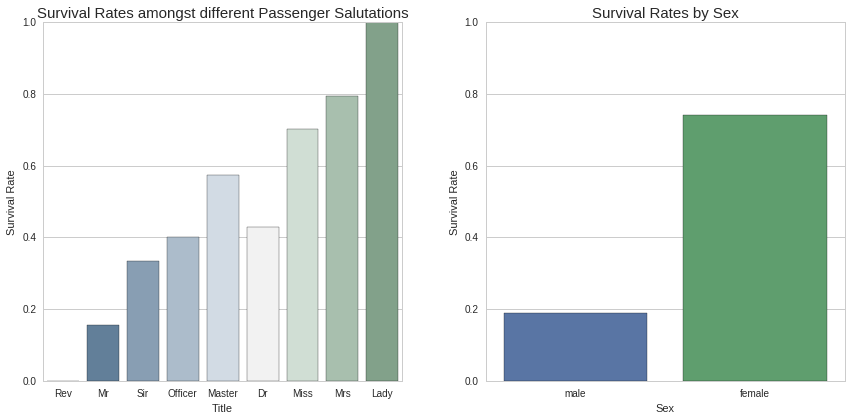

In [18]:
# title_survived = pd.crosstab(titanic_data.Title.astype(str),survived_new, colnames= ['Outcome'])
# title_survived = title_survived.apply(lambda x: x/x.sum(), axis= 1)
# title_survived = title_survived.unstack().reset_index()
# title_survived.columns = ['Outcome', 'Title', 'Rate']
# title_survived.sort_values(['Outcome' , 'Rate'], inplace = True)
# sns.barplot('Title', 'Rate', 'Outcome',title_survived ,ci=False, ax= ax1, palette= 'muted')

sns.set(style = 'whitegrid')
fig = plt.figure(figsize= (12,6))
ax1 = plt.subplot2grid((1,2), (0,0))
sns.barplot('Title', y= 'Survived', order = ['Rev', 'Mr', 'Sir', 'Officer', 'Master', 'Dr', 'Miss', 'Mrs', 'Lady'], 
            data = titanic_data, ci = False, ax = ax1, palette = sns.diverging_palette(245, 135, l=40, n=11, center="light"))
ax1.set_title('Survival Rates amongst different Passenger Salutations', size = 15)
ax1.set_ylabel('Survival Rate')

ax2 = plt.subplot2grid((1,2), (0,1))
sns.barplot('Sex', y= 'Survived', data = titanic_data, ci = False)
ax2.set_title('Survival Rates by Sex', size = 15)
ax2.set_ylabel('Survival Rate')
ax2.set_ylim(top = 1)
fig.tight_layout();

Visualizing the survival/death rates for our different titles we can see the survival rate generally diminish as we move from left to right. A clear pattern emerges of a stronger female rate of survival - clearly supported by the overall rates of survival between the sexes. It was not a good time to be a male!

From the top level summaries of our variables we saw that three columns have missing values - Cabin, Embarked and Age. Ideally we want to fill these values in as a more complete dataset will be benficial to the questions we ask of the data later. Let's take a look at the missing values in the Embarked variable more closely. Remember from the variable descriptions, there are only 3 unique values this variable can take.

In [19]:
titanic_data[titanic_data.Embarked.isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
61,1,1st Class,"Icard, Miss. Amelie",female,38.0,0,0,80.0,B28,NaN,Miss
829,1,1st Class,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,80.0,B28,NaN,Mrs


Just the two missing values for the Embarked variable - two 1st class passengers staying together in cabin B28. With only a few missing values we should be able to use the remaining passenger data to deduce the missing ports of embarkation. 

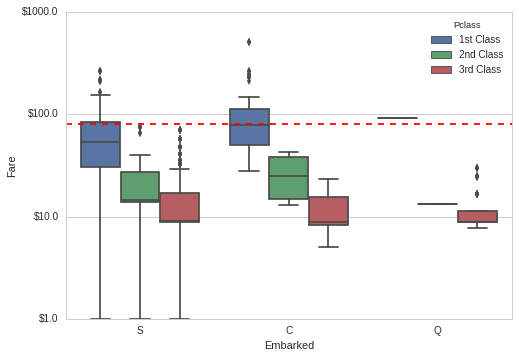

In [21]:
df = titanic_data[titanic_data.Embarked.notnull()]
sns.set(style = 'whitegrid')
g = sns.categorical.boxplot('Embarked', df.Fare + 1,'Pclass', data = df)
g.set_yscale('log')
g.set_ylim(top = 1000)
g.set_yticklabels(['${:.1f}'.format(y) for y in g.get_yticks()])
g.axhline(y=80, ls = '--', color = 'r');


Looking at the distribution of these passenger fares with respect to passenger class and  port of embarkation, there is a strong case to be made for 'C' (Charbourg) being the missing value of our first class passengers. The median cost of a 1st class passengers ticket from Charbourg is around $80 - exactly the price our missing values.

In [22]:
titanic_data.Embarked = np.where(~titanic_data.Embarked.notnull(),'C',titanic_data.Embarked) ## Set missing values to 'C'

In [23]:
titanic_data.isnull().sum() ## see where the remaining missing values lie

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      0
Title         0
dtype: int64

Only two variables left with missing values - Age and Cabin. However, in comparison to 'Embarked' we have many more missing values, Cabin has 687! The same methodology we employed to fill in the missing ports of embarkation would be too laborious with these variables, so will have to use another method, possibly predictive imputation. 

First let's take a closer look at the age variable.

/home/gregory/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


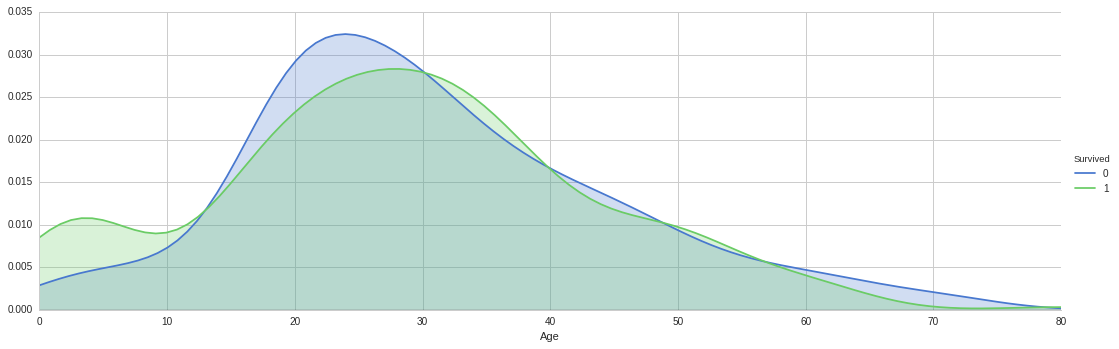

In [109]:
sns.set(style = 'whitegrid', palette= 'muted')
f = sns.FacetGrid(titanic_data, hue = 'Survived', size = 5, aspect = 3)
f.map(sns.kdeplot, "Age", shade = True)
f.set(xlim = (0, max(titanic_data.Age)))
f.add_legend()


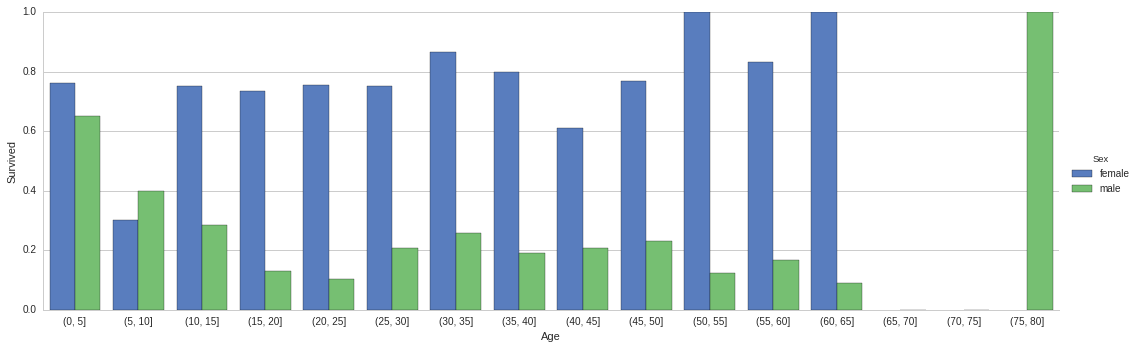

In [153]:
bins = np.linspace(0, 80, 17)
df = titanic_data[['Age', 'Sex', 'Survived']].groupby([pd.cut(titanic_data.Age, bins), 'Sex'],as_index = True)['Survived'].mean().reset_index()
sns.factorplot('Age', 'Survived', 'Sex', data= df, kind = 'bar', size = 5, aspect = 3, ci = False);

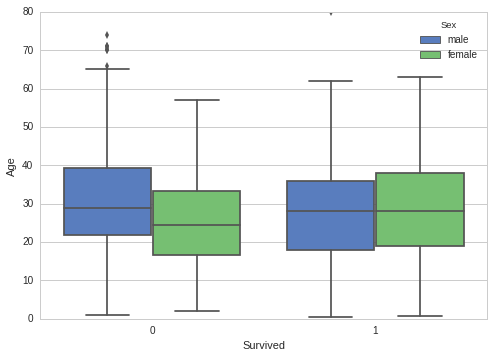

In [155]:
sns.categorical.boxplot('Survived', 'Age', 'Sex', data = titanic_data);

In [ ]:
titanic_data.Cabin.describe()

In [ ]:
titanic_data[titanic_data.Cabin.notnull()].Cabin.values[:60]

In [ ]:
Deck = titanic_data.Cabin.str.extract(r'(\w)\d*')
Deck = pd.Categorical(Deck)
titanic_data['Deck'] = Deck

In [ ]:
Deck.describe()

In [ ]:
titanic_data.dtypes

In [ ]:
pd.in

In [ ]:
survived_new.describe()

In [ ]:
ctab = pd.crosstab(titanic_data.survived_new, titanic_data.Sex, margins = False)
ctab

In [ ]:
figure, axes = plt.subplots(2,4, figsize = (15,12))
mosaicplot.mosaic(titanic_data, ['Pclass', 'survived_new'], ax= axes[0,0] )
mosaicplot.mosaic(titanic_data, ['Sex', 'survived_new'], ax= axes[0,1] )
mosaicplot.mosaic(titanic_data, ['Embarked', 'survived_new'], ax= axes[0,2])
sns.categorical.boxplot('survived_new', 'Age', data = titanic_data, ax= axes[0,3])
g = sns.categorical.boxplot('survived_new', titanic_data.Fare + 1, data = titanic_data, ax= axes[1,0])
g.set_yscale('log')
figure.tight_layout();

In [ ]:
from statsmodels.graphics import mosaicplot
mosaicplot.mosaic(titanic_data, ['Sex','Survived'], horizontal = True);

In [ ]:
sns.set(style = 'whitegrid')
sns.categorical.boxplot('Pclass', 'Age', 'Survived', data = titanic_data)

In [ ]:
g = sns.factorplot('Pclass', 'Survived', data = titanic_data, size = 6, kind = 'bar', ci= None)
g.set_axis_labels("Passenger Class", "Survival Rate").set_titles("{col_name} {col_var}").set(ylim=(0, 1)).despine(left=True);


In [ ]:
sns.categorical.barplot('Pclass', 'Survived', data = titanic_data, ci= )


In [ ]:
titanic = sns.load_dataset('titanic')
g = sns.factorplot("alive", col="deck", col_wrap=4,data=titanic[titanic.deck.notnull()], kind="count", size=2.5, aspect=.8)

In [ ]:
g = sns.factorplot(x="age", y="embark_town",
hue="sex", row="class",data=titanic[titanic.embark_town.notnull()],orient="h", size=2, aspect=3.5, palette="Set3",kind="violin", split=True, cut=0, bw=.2)

In [ ]:
g = sns.factorplot(x="who", y="survived", col="class", data=titanic, saturation=.5, kind="bar", ci=None, aspect=.6)
(g.set_axis_labels("", "Survival Rate").set_xticklabels(["Men", "Women", "Children"]).set_titles("{col_name} {col_var}").set(ylim=(0, 1)).despine(left=True))

In [ ]:
sns.set()

df = sns.load_dataset("iris")
sns.pairplot(df, hue="species")

In [ ]:
crashes.sort_values('total', ascending = False)

In [ ]:

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Load the example car crash dataset
crashes = sns.load_dataset("car_crashes").sort_values("total", ascending=False)

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="total", y="abbrev", data=crashes,
            label="Total", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="alcohol", y="abbrev", data=crashes,
            label="Alcohol-involved", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 24), ylabel="",
       xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)

In [ ]:
sns.set(style="whitegrid")

# Load the example exercise dataset
df = sns.load_dataset("exercise")

# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.factorplot(x="time", y="pulse", hue="kind", col="diet", data=df,
                   capsize=.2, palette="YlGnBu_d", size=6, aspect=.75)
g.despine(left=True);

In [ ]:
df

In [ ]:
test = df.pivot_table('pulse', columns= ['diet', 'kind', 'time'])
test


In [ ]:
sns.factorplot(x="time", y="pulse", hue="kind", col="diet", data=test,
                   capsize=.2, palette="YlGnBu_d", size=6, aspect=.75)